# Imports

In [1]:
import xopt
import concurrent.futures
import os
import time
from UTILITY_quickstart import *

In [2]:
multiplicity_count = 1 # 36 # 24
tasks_per_node = 140
num_tasks = int(multiplicity_count * tasks_per_node)
print(f"Multiplicity: {multiplicity_count}")
print(f"Tasks per node: {tasks_per_node}")
print(f"Number of jobs requested: {num_tasks}")
print(f"Available cores on node: {len(os.sched_getaffinity(0))}")

importedDefaultSettings = loadConfig(f'setLattice_configs/2025-02-25_oneBunch_baseline.yml')

Multiplicity: 1
Tasks per node: 140
Number of jobs requested: 140
Available cores on node: 256


### Make Synthetic Distribution

In [3]:
# From E. Cropp RedPill Helper_functions.py #
#############################################
def Gaussian_Dist_Maker(n,mu,sigma,lSig,rSig):
    """
    This function returns a truncated gaussian distribution of quasi-random particles.  This uses the Halton series
    
    Argument:
    n -- int number of particles
    mu -- float: center of distribution/mean
    sigma -- float: std of distribution
    lSig -- float number of sigma at which to truncate Gaussian left
    rSig -- float number of sigma at which to truncate Gaussian right
    """
    # Check inputs
    try: n = int(n)
    except: raise ValueError("n is not an int!")
    
    try: mu = float(mu)
    except: raise ValueError("mu is not a float!")
    
    try: sigma = float(sigma)
    except: raise ValueError("sigma is not a float!")
    
    try: lSig = float(lSig)
    except: raise ValueError("lSig is not a float!")
    
    try: rSig = float(rSig)
    except: raise ValueError("rSig is not a float!")
    
    
    # get and shuffle n samples from halton series
    h=scipy.stats.qmc.Halton(1)
    X0=h.random(n=n)
    np.random.shuffle(X0)
    
    # Make these into Gaussian and return
    X0=X0*(1-(1-scipy.stats.norm.cdf(lSig))-(1-scipy.stats.norm.cdf(rSig)))
    X0=X0+(1-scipy.stats.norm.cdf(lSig))
    GaussDist = mu + np.sqrt(2)*sigma*scipy.special.erfinv(2*X0-1)
    return np.squeeze(GaussDist)

### Initialize nominal parameters and jitter margins

In [4]:
# I think L0B, L1, L2, L3 amplitudes can be jittered by adding/subtracting to <Stage>EnergyOffset.
nominal_charge             = 1600 # pC
nominal_gun_theta0_deg     = 29.3-90
nominal_gun_rf_field_scale = 119/2.44885*1e6
nominal_L0A_Phase          = 29
nominal_L0A_Amp            = 30e6
nominal_L0B_Phase          = importedDefaultSettings['L0BPhaseSet']
nominal_L0BF_Amp           = 5.95e7
nominal_L1_Phase           = importedDefaultSettings['L1PhaseSet']
nominal_L1_Amp             = 0.335e9 - 0.125e9
nominal_L2_Phase           = importedDefaultSettings['L2PhaseSet']
nominal_L2_Amp             = 4.5e9 - 0.335e9
nominal_L3_Phase           = importedDefaultSettings['L3PhaseSet']
nominal_L3_Amp             = 10.0e9 - 4.5e9

# values obtained from `2024 run` column of https://docs.google.com/spreadsheets/d/1xeCUImz5uFSq6QA3wV91dG38s-8cyVXQMGw9hjPKa6M/edit?usp=sharing
charge_jitter_percent  = 2.3
gun_Phase_jitter       = 0.15
gun_Amp_jitter_percent = 0.25
L0A_Phase_jitter       = 0.1 # L0APhaseOffset kwarg passed directly into `initializeTao`. Note that it's an *offset*.
L0A_Amp_jitter_percent = 0.06
L0B_Phase_jitter       = 0.1
L0B_Amp_jitter_percent = 0.5
L1A_Phase_jitter       = 0.7
L1A_Amp_jitter_percent = 0.6
L1B_Phase_jitter       = 0.5
L1B_Amp_jitter_percent = 0.7
L2_Phase_jitter        = 0.4
L2_Amp_jitter_percent  = 0.3
L3_Phase_jitter        = 0.4
L3_Amp_jitter_percent  = 0.3

L_str = 'L2'

cal_data = {
    f'{L_str}PhaseSet':[nominal_L2_Phase - L2_Phase_jitter, nominal_L2_Phase + L2_Phase_jitter],
}

# Beam output locations
locations = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT']

### Make evaluation points and initialize in-situ diagnostics

In [5]:
step = 0.2
points = {f'L2PhaseSet': np.arange(-42, -34+step/2, step) }
points = pd.DataFrame(points)

# Diagnostic keys
diagnostic_keys = [
    'energy',
    'peak current 50',
    'peak current 100',
    'peak current 200',
    'sigma_x',
    'sigma_y',
    'sigma_z',
    'emittance_x',
    'emittance_y',
    'pmd_emittance_x',
    'pmd_emittance_y',
    'energy spread',
]

# Parallelizable jitter function

In [6]:
path_conda = '/global/homes/m/maxvarv/miniforge3/envs/bmad/bin/'

output_path = f'/pscratch/sd/m/maxvarv/Jitter_2025_02_25/L2Phase_working_point_scan'
os.makedirs(output_path, exist_ok=True)

def worker(overrides):
    start_time = time.time()    

    # initialize diagnostics dict
    diagnostics = { loc: {key: 0.0 for key in diagnostic_keys} for loc in locations }
    
    tao, unique_ID = initializeTao(
            inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],
            GFILESuffix = f'2024-10-22_distgen_onebunch.yaml',
            csrTF = True,
            runImpactTF = False,
            # impactGridCount = 32,          # unused when `runImpactTF = False`
            # numMacroParticles = 5 * 32**3, # unused when `runImpactTF = False` (still technically used if uncommented, but we want to use the h5 input file to define this)
            # solenoidTValue = -0.41, # uncomment if explicitly running impact-T!
            # impactChargepC = point['ChargepC'], # adjust bunch charge (when jittering in impact-T),
            command = path_conda + 'ImpactTexe',    
            command_mpi = path_conda + 'ImpactTexe-mpi',
            mpi_run = '/global/u1/m/maxvarv/miniforge3/envs/bmad/bin/mpirun --map-by :OVERSUBSCRIBE -n {nproc} {command_mpi}',
            scratchPath = output_path,
            randomizeFileNames = True,
    	)
    
    setLattice(tao, **importedDefaultSettings)
    # disableAutoQuadEnergyCompensation(tao)
    
    try:
                
        # without energy compensation
        # setLinacPhase(tao, L_str, overrides[f'{L_str}PhaseSet']) # adjust L2 Phase

        # with energy compensation
        setLattice(tao, **(importedDefaultSettings | { 'L2PhaseSet' : overrides['L2PhaseSet'] }))
        
        trackBeam(tao, **importedDefaultSettings)
    
        result = {'Unique ID': unique_ID}
        
        # make directory if it doesn't already exist
        os.makedirs(f'{output_path}/{unique_ID}', exist_ok=True)
        
        for location in locations:
            P = getBeamAtElement(tao, location)

            diagnostics[location]['energy'          ] = P['mean_energy']
            diagnostics[location]['peak current 50' ] = P.slice_statistics(slice_key='t', n_slice=50)['current'].max()
            diagnostics[location]['peak current 100'] = P.slice_statistics(slice_key='t', n_slice=100)['current'].max()
            diagnostics[location]['peak current 200'] = P.slice_statistics(slice_key='t', n_slice=200)['current'].max()
            diagnostics[location]['sigma_x'         ] = smallestIntervalImpliedSigma(P.x) # horizontal spot size
            diagnostics[location]['sigma_y'         ] = smallestIntervalImpliedSigma(P.y) # vertical spot size
            diagnostics[location]['sigma_z'         ] = smallestIntervalImpliedSigma(P.z) # bunch length
            diagnostics[location]['emittance_x'     ] = smallestIntervalImpliedEmittance(P, plane = 'x', percentage = 0.9)
            diagnostics[location]['emittance_y'     ] = smallestIntervalImpliedEmittance(P, plane = 'y', percentage = 0.9)
            diagnostics[location]['pmd_emittance_x' ] = P.norm_emit_x
            diagnostics[location]['pmd_emittance_y' ] = P.norm_emit_y
            diagnostics[location]['energy spread'   ] = P.std('energy')/P.avg('energy')
            
    	    # write to output_path
            P.write(f'{output_path}/{unique_ID}/{location}.h5')
    finally:
        tao.close_subprocess()

        
        diagnostics = pd.DataFrame(diagnostics)
        diagnostics.to_csv(f'{output_path}/{unique_ID}/diagnostics.csv')

        print(f'Run {unique_ID} elapsed time: {(time.time() - start_time) / 60:.1f} minutes')
        
    return result

In [7]:
print(f'Number of evaluation points: {points.index.stop}')

evaluator1=xopt.evaluator.Evaluator(
                                    function=worker, 
                                    function_kwargs={},
                                    max_workers=points.index.stop,
                                    executor=concurrent.futures.ProcessPoolExecutor(max_workers=points.index.stop),
                                    vectorized=False,
                                   )

results = pd.DataFrame.from_dict( evaluator1.evaluate_data(points) )
results.to_csv(f'{output_path}/xopt_out.csv', index=False)

Number of evaluation points: 41
Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to: Environment set to:  Environment set to: Environment set to: Environment set to: Environment set to: Environment set to:  Environment set to:   Environment set to:     Environment set to: Environment set to:   Environment set to: Environment set to:      /global/u1/m/maxvarv/FACET2-Bmad-PyTaoEnvironment set to: Environment set to: Environment set to:  Environment set to: Environment set to: Environment set to: Environment set to:  Environment set to:  /global/u1/m/maxvarv/FACET2-Bmad-PyTao Environment set to:  Environment set to:    /global/u1/m/maxvarv/FACET2-Bmad-PyTao/global/u1/m/maxvarv/FACET2-Bmad-PyTao /global/u1/m

/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/ma

Run 3961276287378672543 elapsed time: 27.2 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 9227305730793691337 elapsed time: 27.3 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 5415502994004157947 elapsed time: 27.3 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 6624381754685589620 elapsed time: 27.3 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 5102623702678228476 elapsed time: 27.3 minutes
Run 11233531851702782308 elapsed time: 27.3 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 450993872326887715 elapsed time: 27.4 minutes
Run 1697356211082700802 elapsed time: 27.4 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 8418009061248002882 elapsed time: 27.4 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 7760798084913444616 elapsed time: 27.4 minutes
Run 18131646773775244654 elapsed time: 27.4 minutes
Run 12771558819269539698 elapsed time: 27.4 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 6043433082072491965 elapsed time: 27.4 minutes
Run 4349972142887312511 elapsed time: 27.4 minutes
Run 11762973231866967052 elapsed time: 27.4 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 9334364712771920709 elapsed time: 27.5 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 6751802343513485287 elapsed time: 27.5 minutes
Run 16504473662457459274 elapsed time: 27.5 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 6346379163620049633 elapsed time: 27.5 minutes
Run 2983231197687515290 elapsed time: 27.6 minutes


/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 1058087783245350270 elapsed time: 27.6 minutes
Run 5711285347769452566 elapsed time: 27.6 minutes
Run 1549981219829731940 elapsed time: 27.6 minutes
Run 11183297822139712630 elapsed time: 27.6 minutes
Run 2958666226926234786 elapsed time: 27.6 minutes
Run 15624557311009307902 elapsed time: 27.6 minutes
Run 1993753485349657334 elapsed time: 27.7 minutes
Run 1160135194828280048 elapsed time: 27.7 minutes
Run 6347086056132056925 elapsed time: 27.7 minutes
Run 11048313186851109952 elapsed time: 27.7 minutes
Run 15475607897711745442 elapsed time: 27.7 minutes
Run 10688218253493037671 elapsed time: 27.7 minutes
Run 16726294949711016885 elapsed time: 27.8 minutes
Run 1157359911964738502 elapsed time: 27.8 minutes
Run 1129338070284224241 elapsed time: 27.8 minutes
Run 7540108474113257702 elapsed time: 27.8 minutes
Run 17085015296692257239 elapsed time: 27.8 minutes
Run 11140782984804151089 elapsed time: 27.8 minutes
Run 2342485506985603628 elapsed time: 27.8 minutes
Run 7239741181359573413

/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:501: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Run 18186052058942456298 elapsed time: 28.5 minutes


Process ForkProcess-40:
Process ForkProcess-2:
Process ForkProcess-38:
Process ForkProcess-14:
Process ForkProcess-6:
Process ForkProcess-25:
Process ForkProcess-15:
Process ForkProcess-34:
Process ForkProcess-30:
Process ForkProcess-17:
Process ForkProcess-39:
Process ForkProcess-5:
Process ForkProcess-26:
Process ForkProcess-7:
Process ForkProcess-1:
Process ForkProcess-20:
Process ForkProcess-33:
Process ForkProcess-37:
Process ForkProcess-12:
Process ForkProcess-35:
Process ForkProcess-13:
Process ForkProcess-11:
Process ForkProcess-8:
Process ForkProcess-3:
Process ForkProcess-10:
Process ForkProcess-22:
Process ForkProcess-28:
Process ForkProcess-23:
Process ForkProcess-41:
Process ForkProcess-32:
Process ForkProcess-27:
Process ForkProcess-31:
Process ForkProcess-9:
Process ForkProcess-36:
Process ForkProcess-19:
Process ForkProcess-21:
Process ForkProcess-4:
Process ForkProcess-18:
Process ForkProcess-24:
Process ForkProcess-16:
Process ForkProcess-29:
Traceback (most recent ca

# Visualize results

In [7]:
xopt_out = pd.read_csv(f'{output_path}/xopt_out.csv')

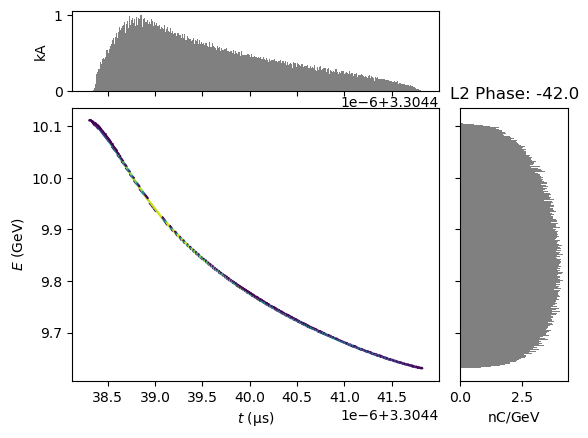

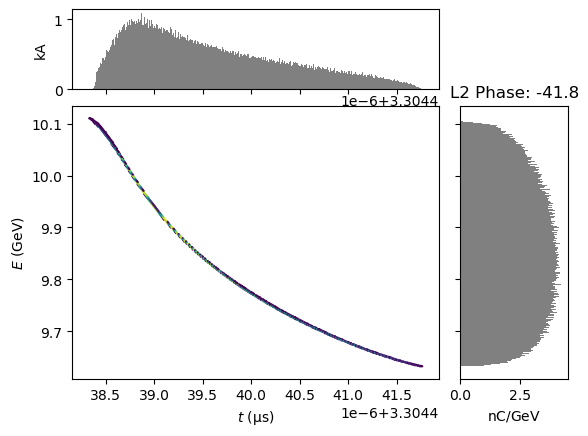

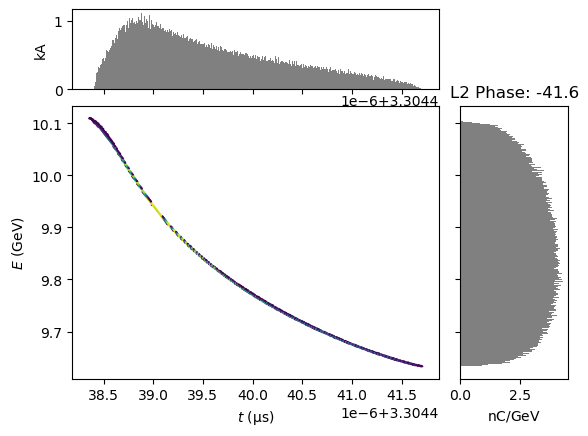

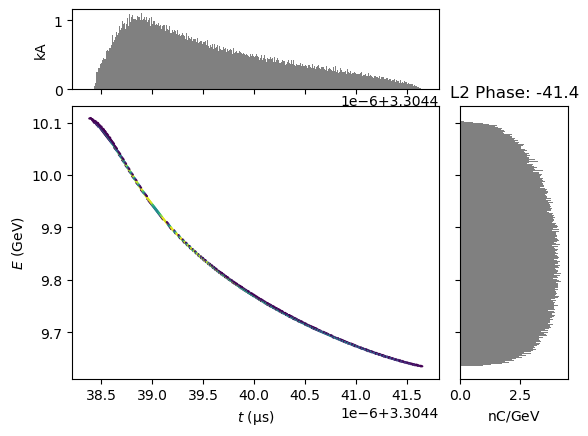

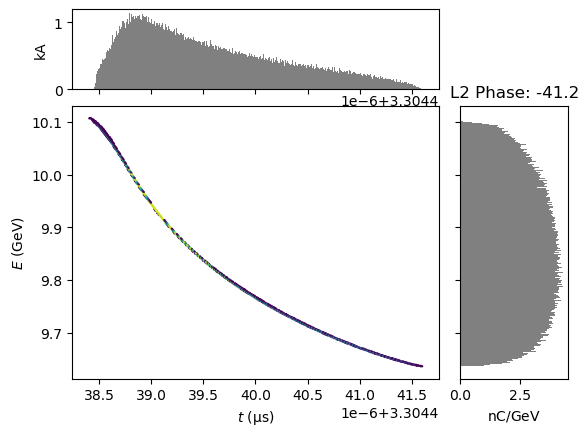

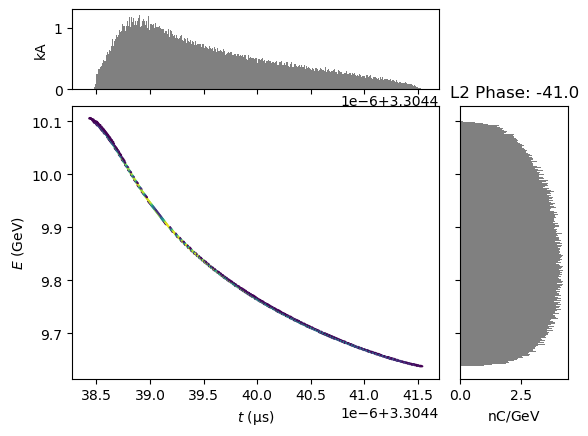

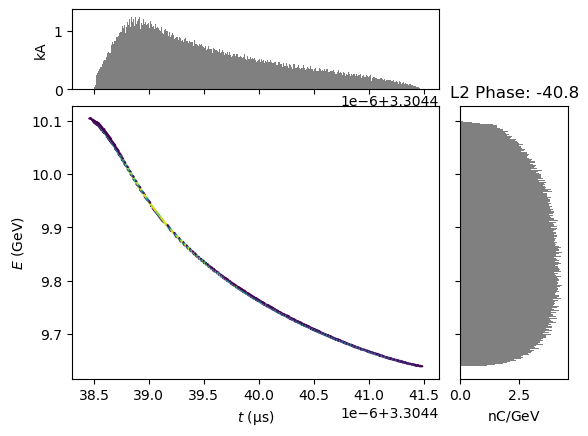

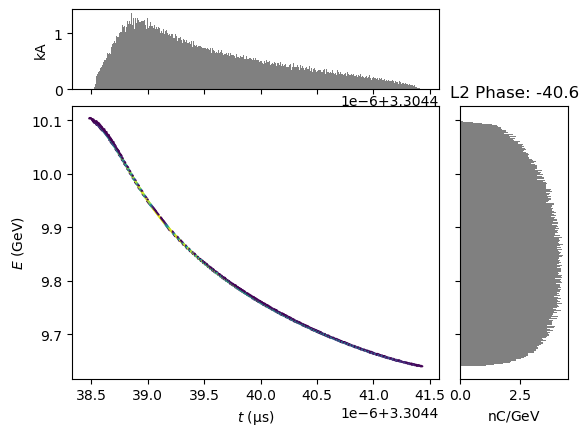

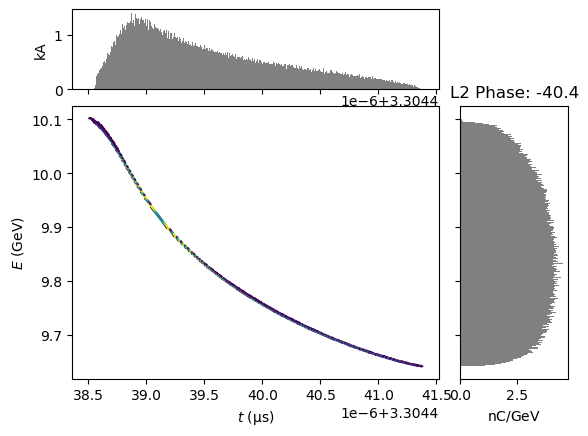

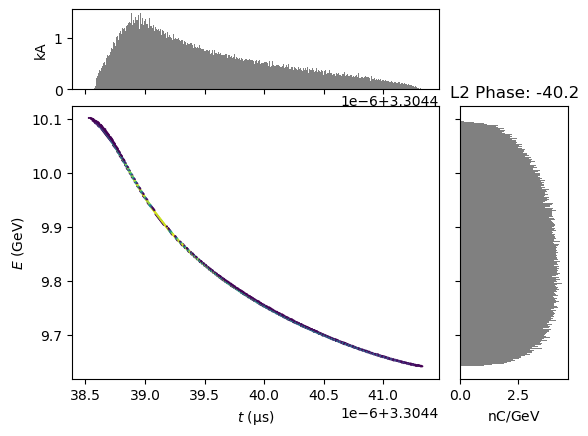

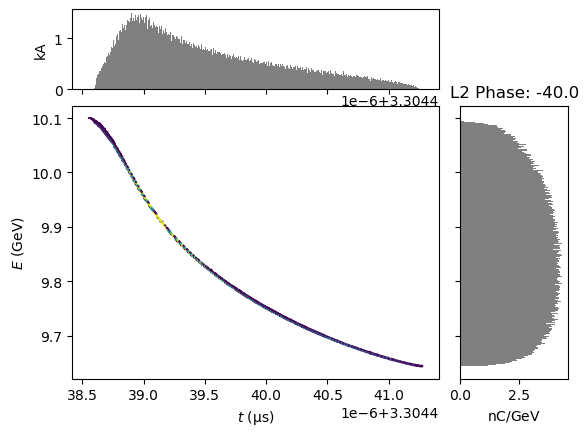

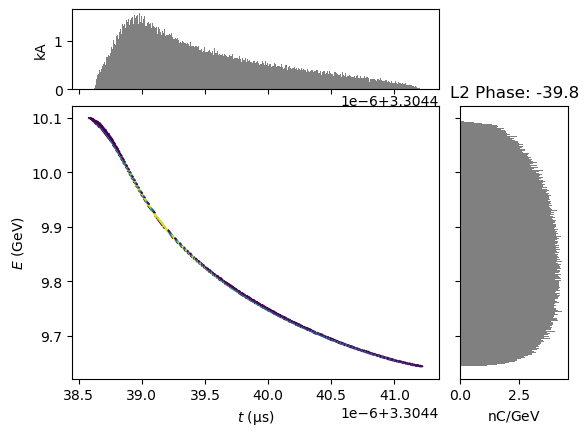

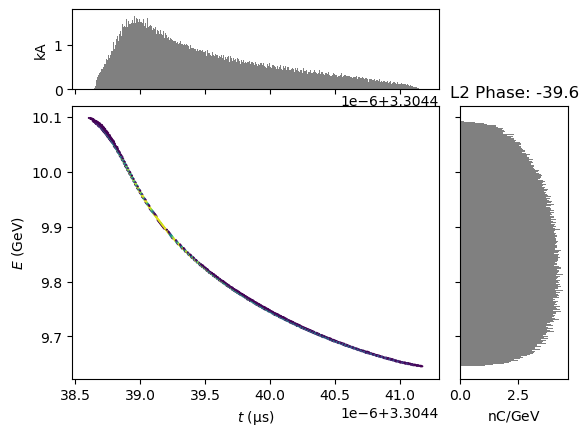

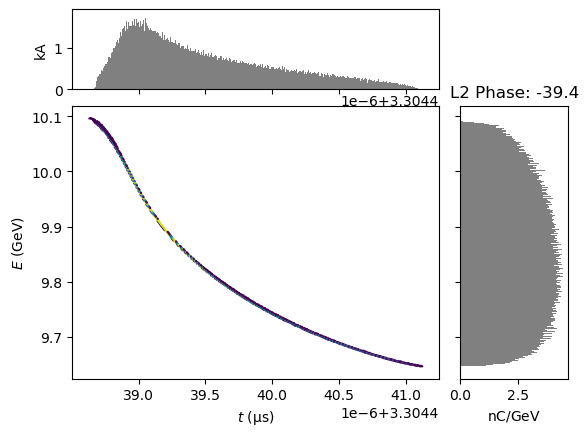

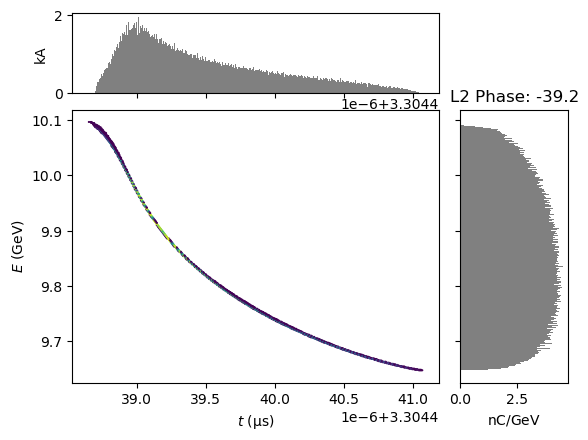

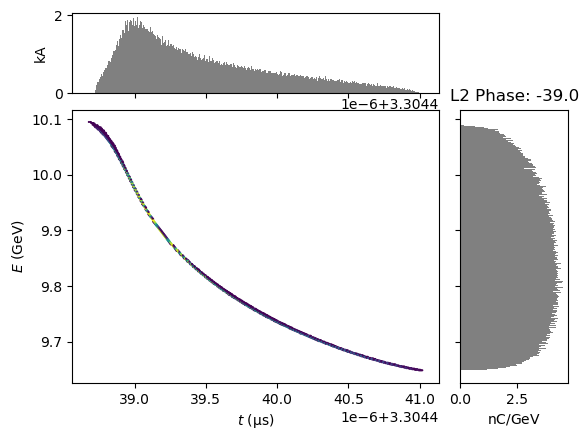

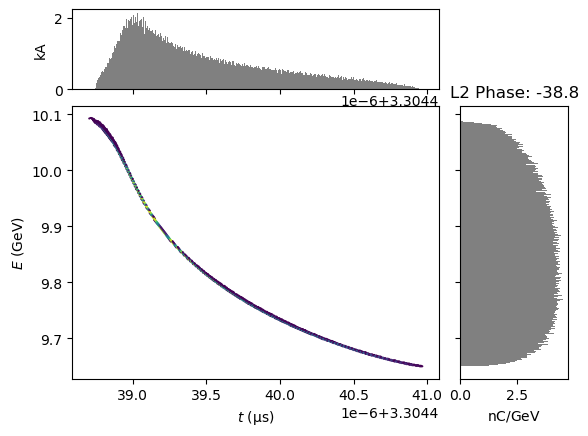

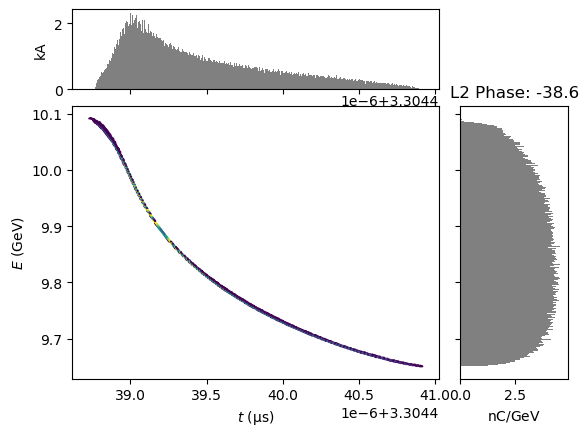

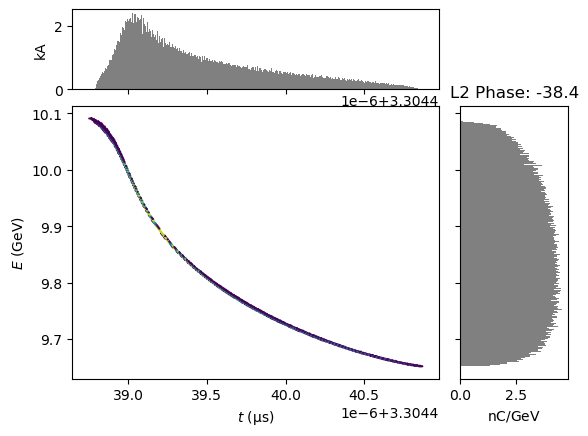

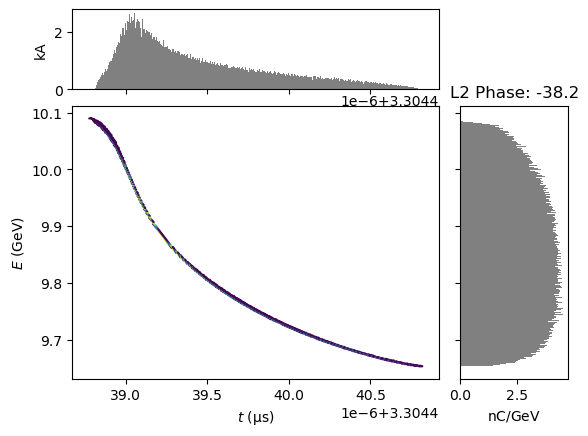

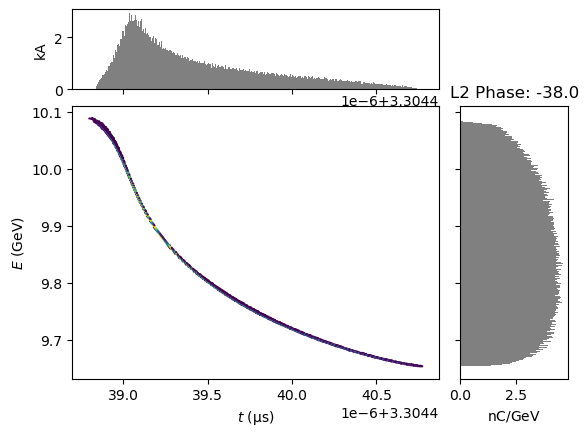

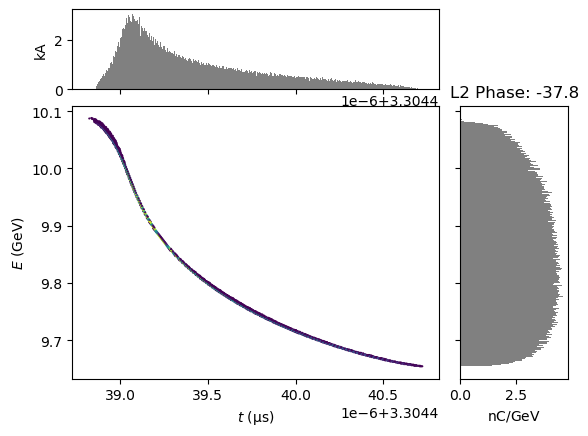

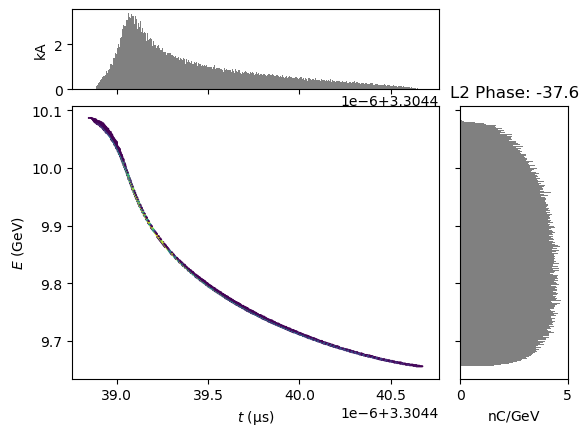

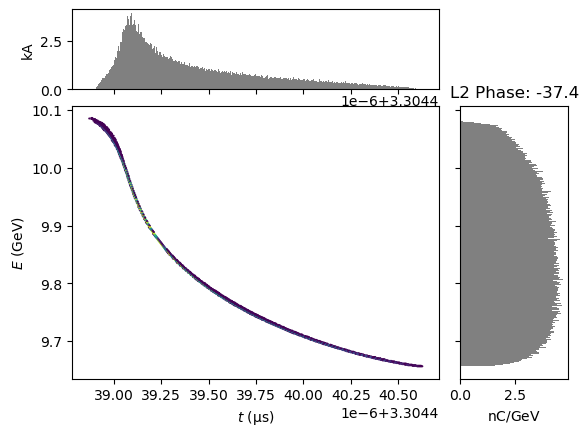

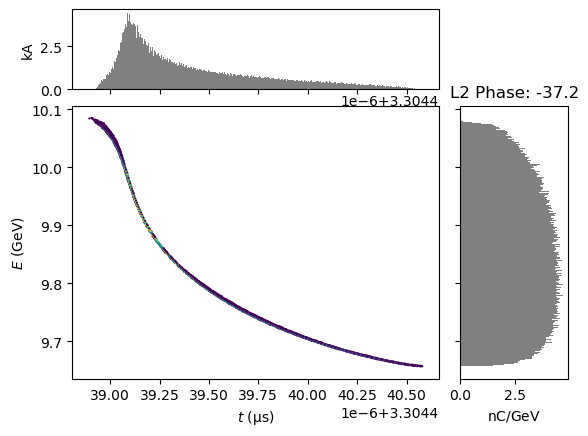

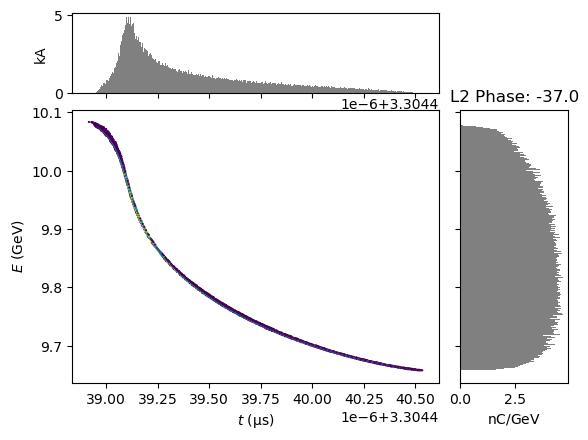

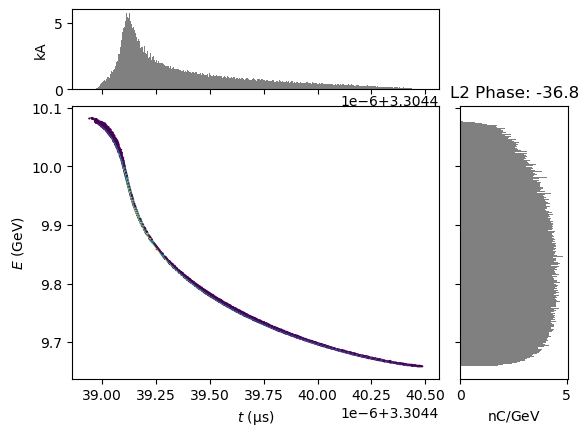

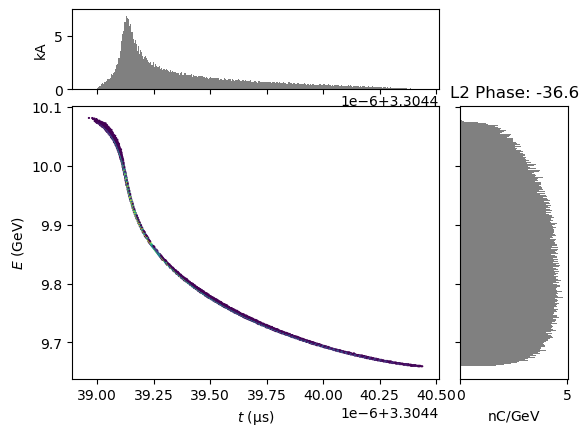

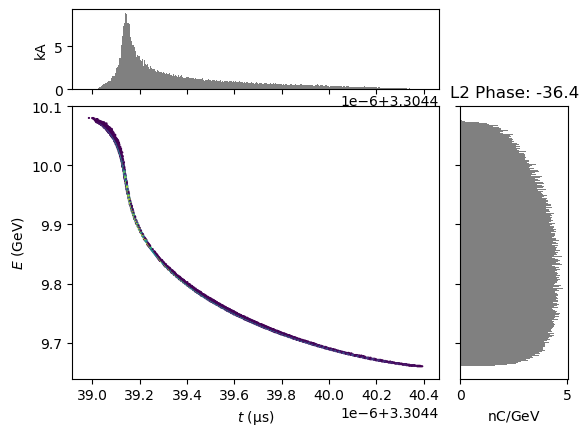

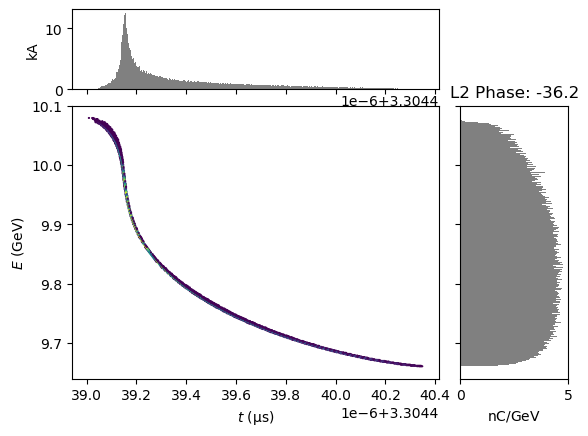

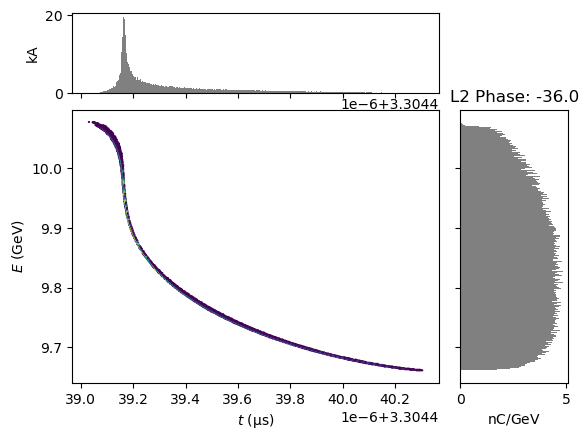

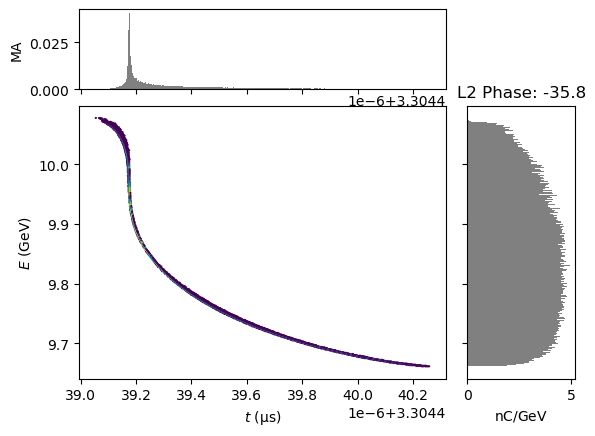

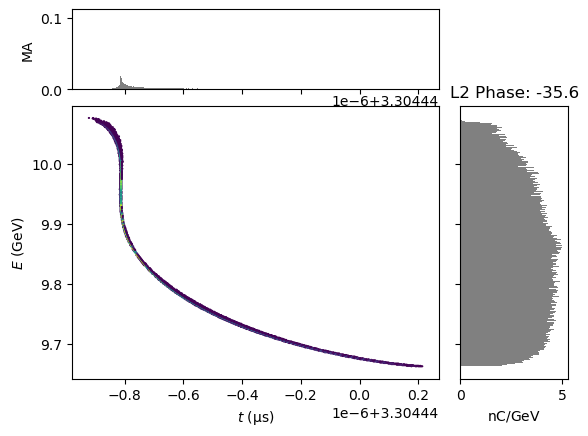

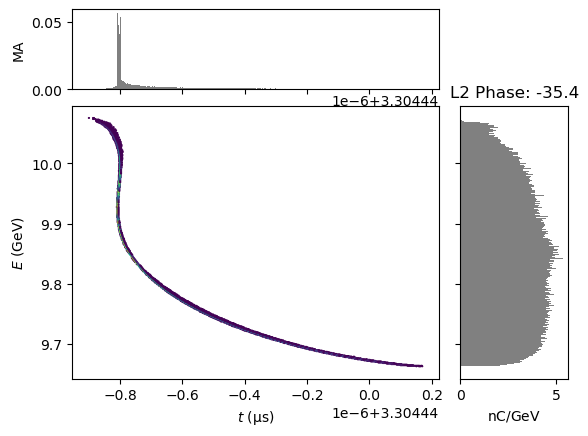

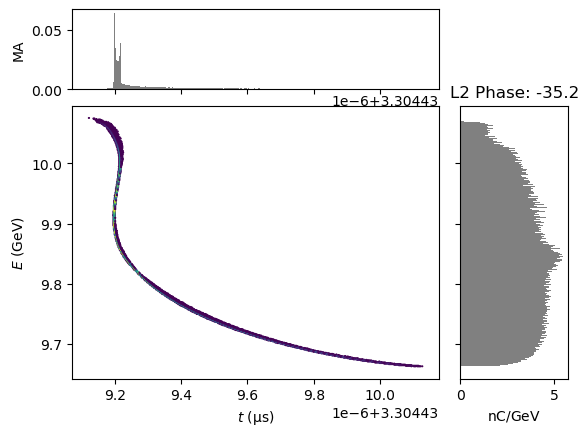

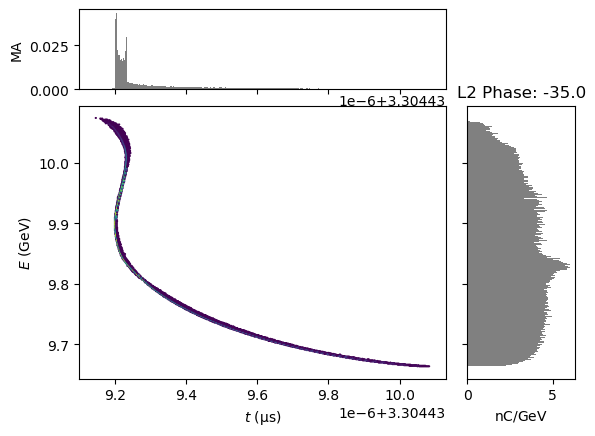

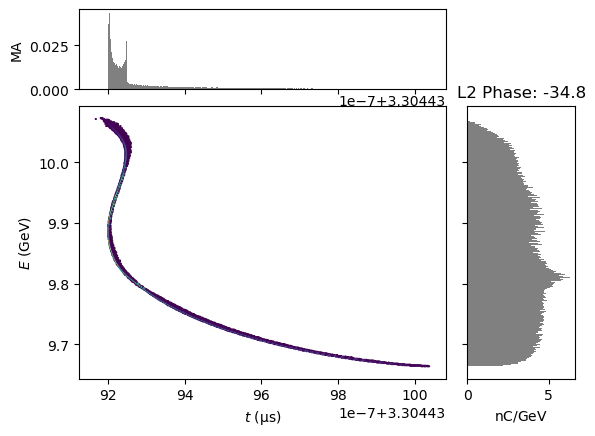

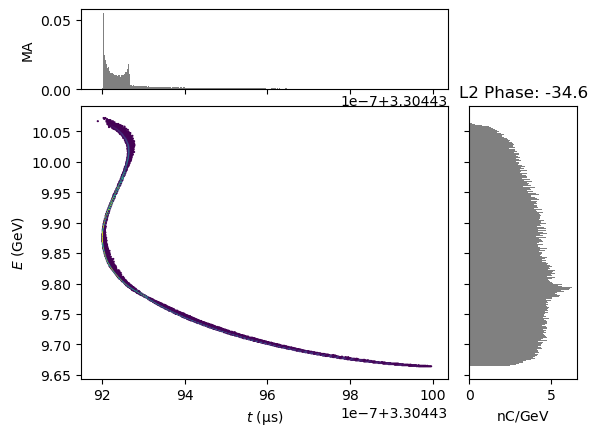

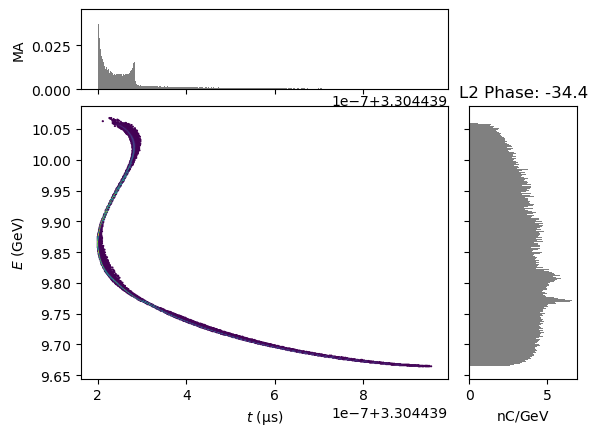

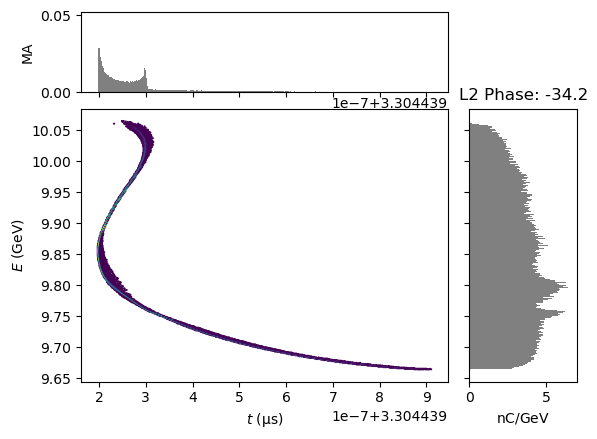

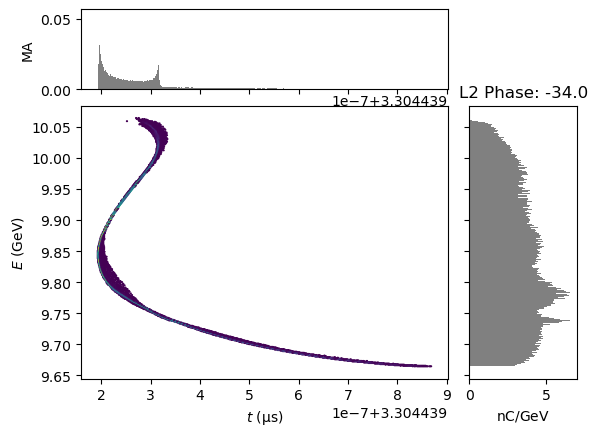

In [9]:
# -35.8 deg is best compression
# xopt_out.iloc[31]
location = 'PENT'

for idx,uid in enumerate(xopt_out['Unique ID']):
    pts = pmd_beamphysics.ParticleGroup(f"{output_path}/{uid}/{location}.h5")
    pts.plot('t','energy', bins=400)
    plt.title(f'L2 Phase: {results['L2PhaseSet'].iloc[idx]:.1f}')
    plt.show()

## Check plots for -35.8 deg

In [7]:
def gather_diagnostics(location: str) -> list:
    return [ diagnostics[xopt_out['Unique ID'].iloc[i]][location][key]*key_scale_dict[key] for i in range(len(diagnostics)) ]

formatter = plt.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))

compare_energy    = {'ENDINJ': 125e6, 'BC11CEND': 335e6, 'ENDBC14_2': 4.5e9, 'ENDFF20': 1e10}
compare_z         = {'ENDINJ': 557e-6, 'BC11CEND': 339e-6, 'ENDBC14_2': 24e-6, 'ENDFF20': 7.6e-6}
compare_emittance = {'ENDINJ': {'x': 3.6e-6, 'y': 2.7e-6}, 'ENDL3F_2': {'x': 7.1e-6, 'y': 4.6e-6}}
compare_e_spread  = {'ENDINJ': 0.1e-2, 'BC11CEND': 0.5e-2, 'ENDBC14_2': 1e-2, 'ENDFF20': 0.9e-2}

key_label_dict = {
    'energy'             : 'Mean energy [GeV]',
    'peak current 50'    : 'Peak current (50 bins) [kA]',
    'peak current 100'   : 'Peak current (100 bins) [kA]',
    'peak current 200'   : 'Peak current (200 bins) [kA]',
    'sigma_x'            : r'RMS horizontal spot size [$\mu m$]',
    'sigma_y'            : r'RMS vertical spot size [$\mu m$]',
    'sigma_z'            : r'RMS bunch length [$\mu m$]',
    'emittance_x'        : r'Normalized $\varepsilon_x$ [$\mu m$]',
    'emittance_y'        : r'Normalized $\varepsilon_y$ [$\mu m$]',
    'pmd_emittance_x'    : r'Built-in pmd normalized $\varepsilon_x$ [$\mu m$]',
    'pmd_emittance_y'    : r'Built-in pmd normalized $\varepsilon_y$ [$\mu m$]',
    'energy spread'      : r'Energy spread [%]',
}

key_scale_dict = {
    'energy'             : 1e-9,
    'peak current 50'    : 1e-3,
    'peak current 100'   : 1e-3,
    'peak current 200'   : 1e-3,
    'sigma_x'            : 1e6,
    'sigma_y'            : 1e6,
    'sigma_z'            : 1e6,
    'emittance_x'        : 1e6,
    'emittance_y'        : 1e6,
    'pmd_emittance_x'    : 1e6,
    'pmd_emittance_y'    : 1e6,
    'energy spread'      : 1e2,
}

In [8]:
xopt_out = pd.read_csv(f'{output_path}/xopt_out.csv')

# filter out any incomplete sims
xopt_out = xopt_out[xopt_out['xopt_error'] == False]

# extract beam diagnostics from each run by the unique ID
diagnostics = {}
# for uid in jitter_numbers['Unique ID']:
for uid in xopt_out['Unique ID']:
# for uid in uids:
    try:
        diagnostics[uid] = pd.read_csv(f'{output_path}/{uid}/diagnostics.csv', index_col=0)
    except:
        print(f'{uid} not imported!')


%time

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 6.44 μs


In [44]:
diagnostics[xopt_out.iloc[31]['Unique ID']]['PENT']

energy              9.851194e+09
peak current 50     5.254024e+04
peak current 100    5.364688e+04
peak current 200    5.461239e+04
sigma_x             3.358016e-05
sigma_y             1.297308e-05
sigma_z             6.084865e-05
emittance_x         5.966342e-05
emittance_y         5.959260e-06
pmd_emittance_x     6.740859e-05
pmd_emittance_y     8.731309e-06
energy spread       1.094584e-02
Name: PENT, dtype: float64

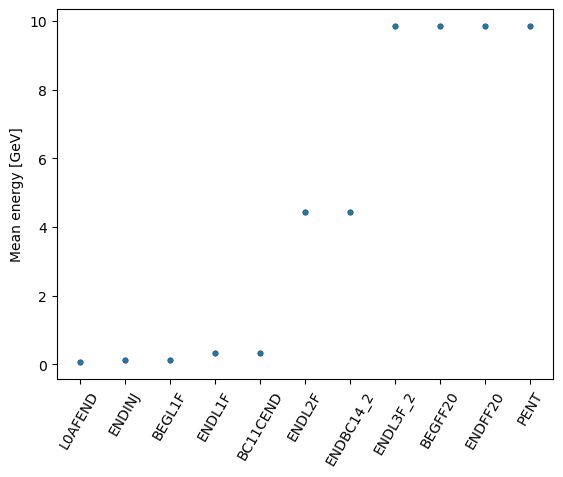

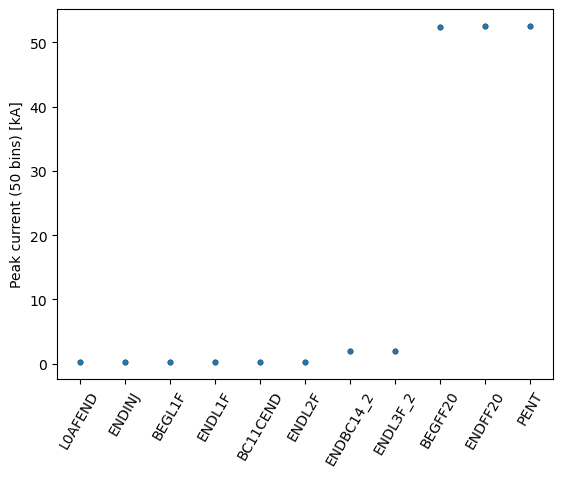

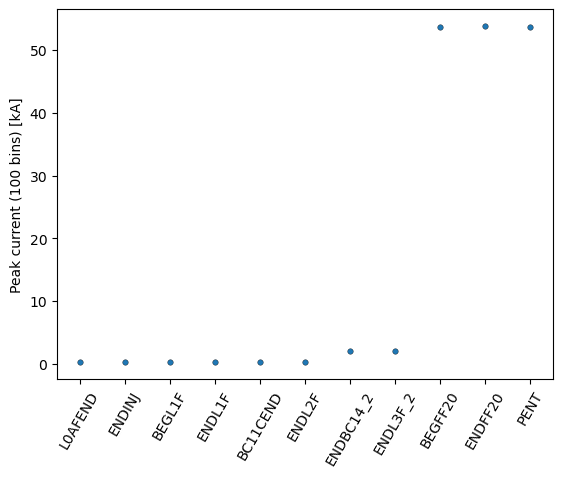

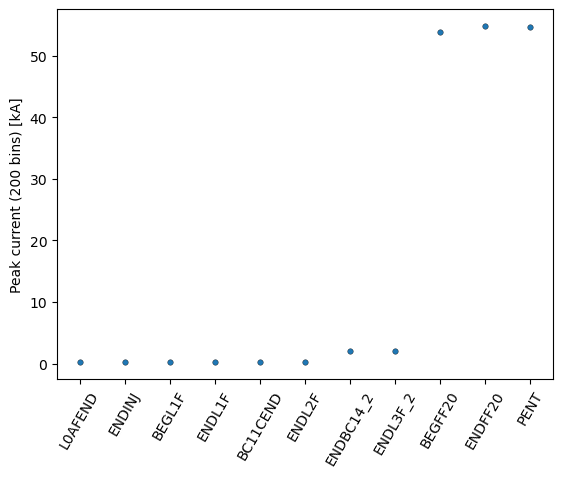

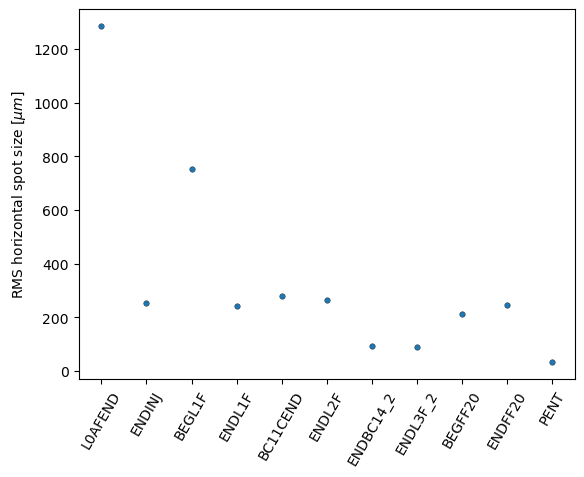

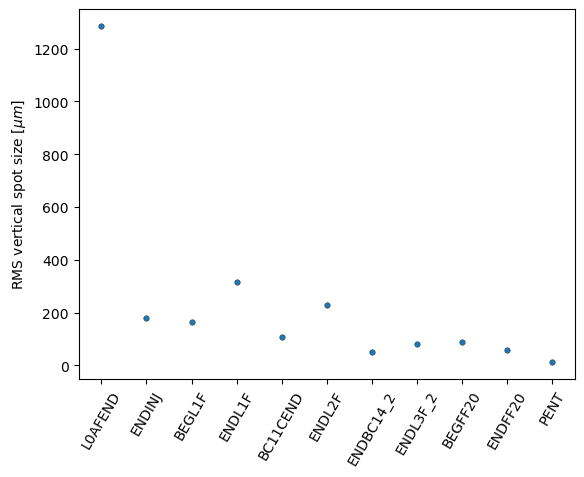

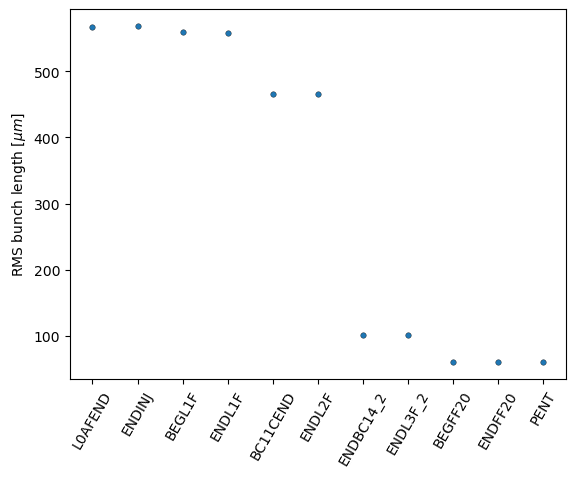

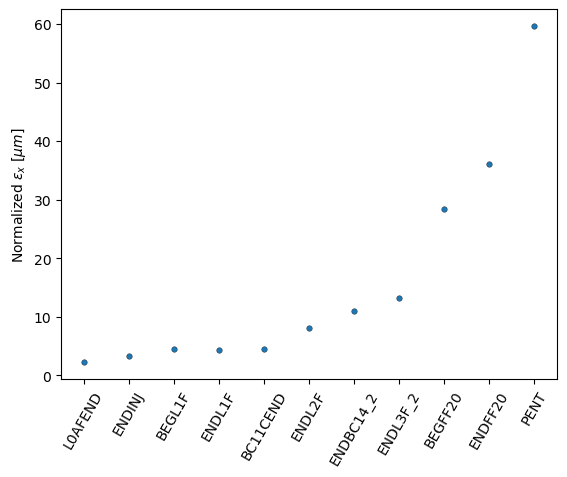

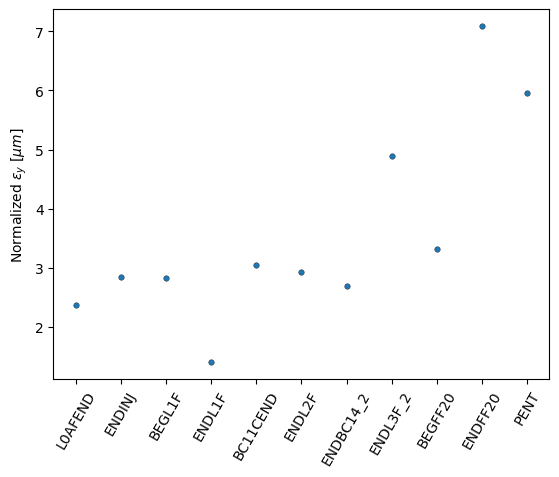

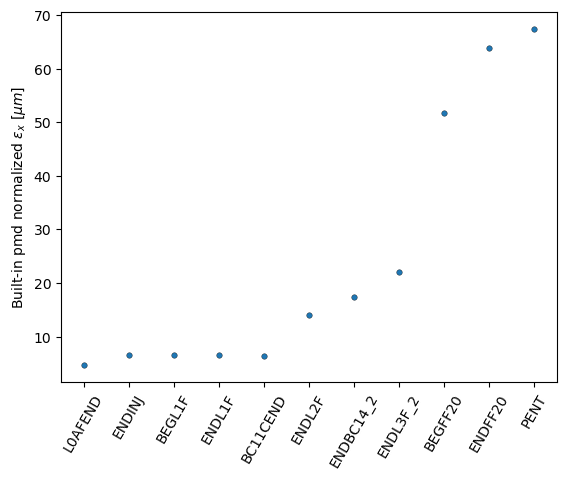

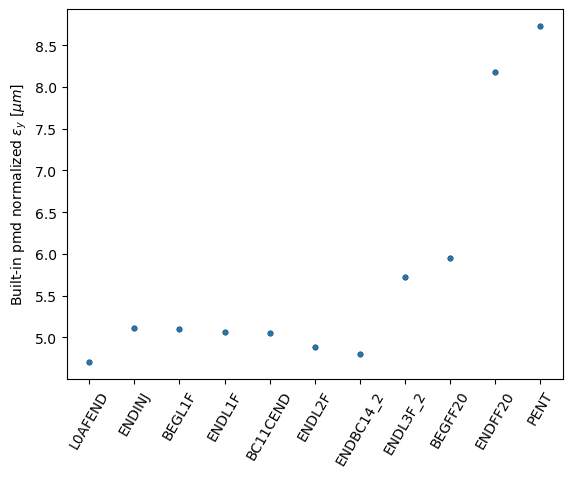

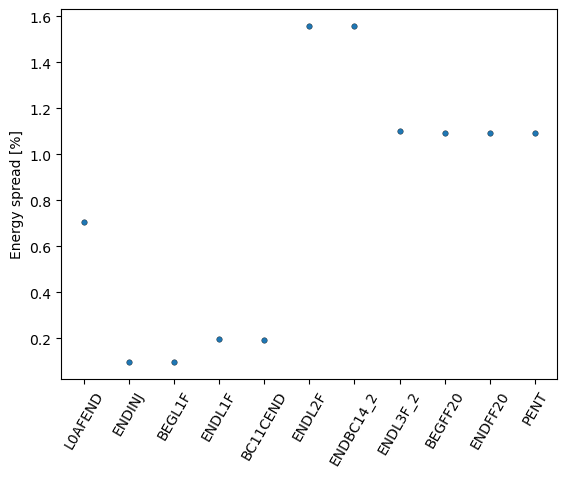

In [48]:
locations = diagnostics[xopt_out.iloc[31]['Unique ID']].keys().to_list()
sz = 16

for key in diagnostics[xopt_out.iloc[31]['Unique ID']]['PENT'].keys():
    plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location][key] * key_scale_dict[key] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                s=sz, edgecolors='k', linewidth=0.25)

    plt.ylabel(key_label_dict[key])
    plt.xticks(rotation=60)

    plt.show()

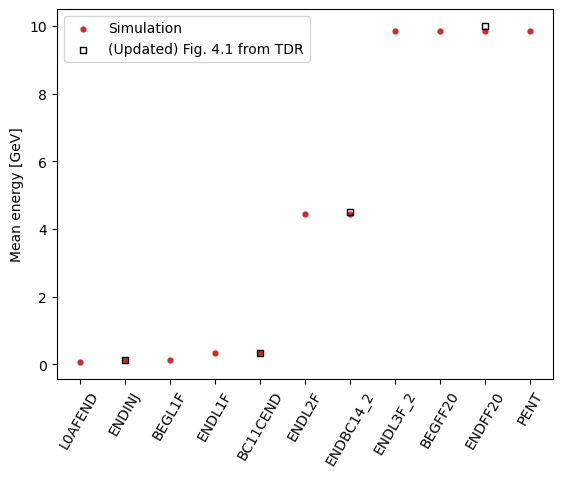

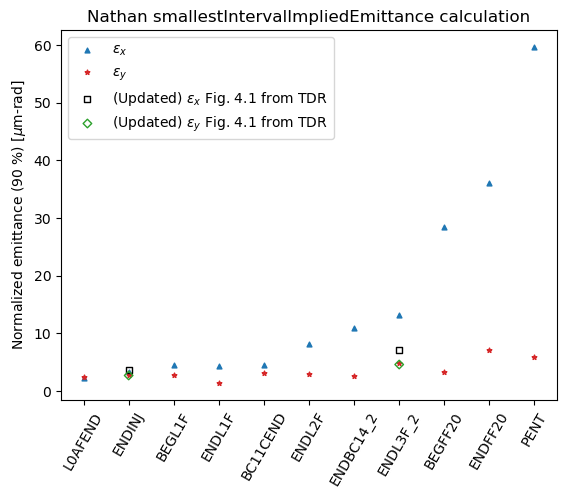

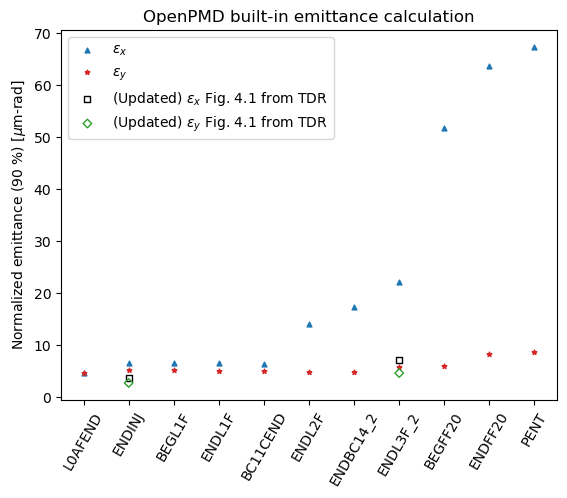

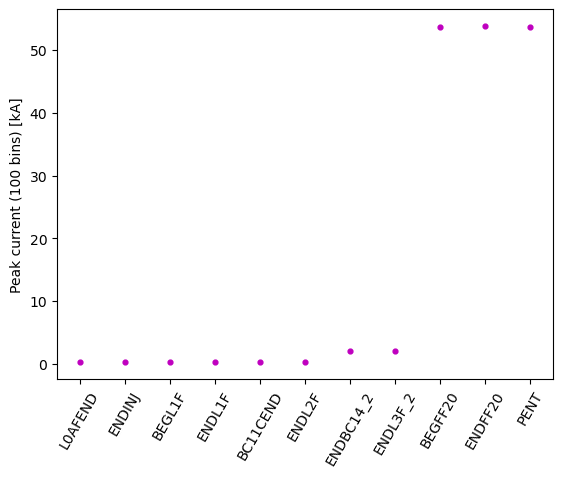

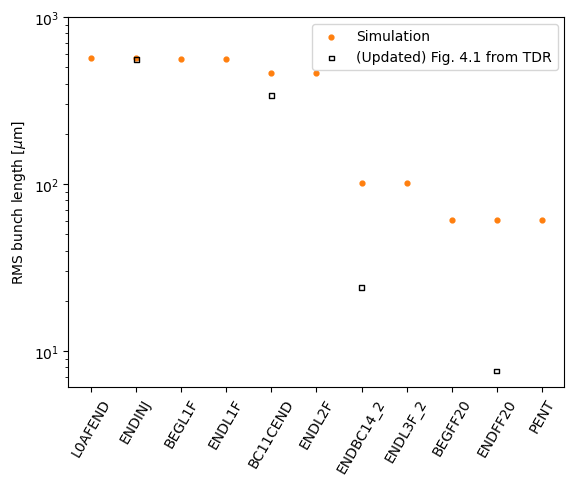

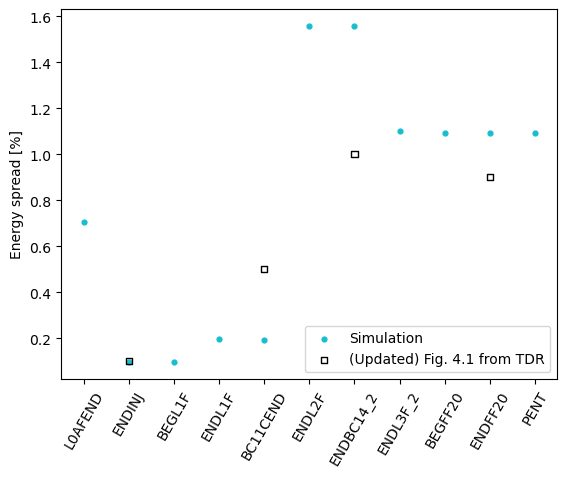

In [11]:
sz = 12

plt.xticks(rotation=60)
plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location]['energy'] * key_scale_dict['energy'] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ], s=sz, c='tab:red')
plt.scatter([key for key in compare_energy.keys()], [val*1e-9 for val in compare_energy.values()], s=sz+7, marker='s', edgecolors='k', facecolor='none')
plt.ylabel('Mean energy [GeV]')
plt.legend(['Simulation','(Updated) Fig. 4.1 from TDR'])
plt.show()

plt.xticks(rotation=60)
plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location]['emittance_x'] * key_scale_dict['emittance_x'] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ], s=sz, c='tab:blue', marker='^')
plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location]['emittance_y'] * key_scale_dict['emittance_y'] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ], s=sz, c='tab:red', marker='*')
plt.scatter([key for key in compare_emittance.keys()], [val['x']*1e6 for val in compare_emittance.values()], s=sz+7, marker='s', edgecolors='k', facecolor='none')
plt.scatter([key for key in compare_emittance.keys()], [val['y']*1e6 for val in compare_emittance.values()], s=sz+7, marker='D', edgecolors='tab:green', facecolor='none')
plt.legend([r'$\varepsilon_x$',r'$\varepsilon_y$',r'(Updated) $\varepsilon_x$ Fig. 4.1 from TDR',r'(Updated) $\varepsilon_y$ Fig. 4.1 from TDR'])
plt.ylabel(r'Normalized emittance (90 %) [$\mu$m-rad]')
plt.title('Nathan smallestIntervalImpliedEmittance calculation')
plt.show()

plt.xticks(rotation=60)
plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location]['pmd_emittance_x'] * key_scale_dict['pmd_emittance_x'] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ], s=sz, c='tab:blue', marker='^')
plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location]['pmd_emittance_y'] * key_scale_dict['pmd_emittance_y'] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ], s=sz, c='tab:red', marker='*')
plt.scatter([key for key in compare_emittance.keys()], [val['x']*1e6 for val in compare_emittance.values()], s=sz+7, marker='s', edgecolors='k', facecolor='none')
plt.scatter([key for key in compare_emittance.keys()], [val['y']*1e6 for val in compare_emittance.values()], s=sz+7, marker='D', edgecolors='tab:green', facecolor='none')
plt.legend([r'$\varepsilon_x$',r'$\varepsilon_y$',r'(Updated) $\varepsilon_x$ Fig. 4.1 from TDR',r'(Updated) $\varepsilon_y$ Fig. 4.1 from TDR'])
plt.ylabel(r'Normalized emittance (90 %) [$\mu$m-rad]')
plt.title('OpenPMD built-in emittance calculation')
plt.show()

plt.xticks(rotation=60)
plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location]['peak current 100'] * key_scale_dict['peak current 100'] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ], s=sz, c='m')
plt.ylabel('Peak current (100 bins) [kA]')
plt.show()

plt.xticks(rotation=60)
plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location]['sigma_z'] * key_scale_dict['sigma_z'] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ], s=sz, c='tab:orange')
plt.scatter([key for key in compare_z.keys()], [val*1e6 for val in compare_z.values()], s=sz, marker='s', edgecolors='k', facecolor='none')
plt.ylabel(r'RMS bunch length [$\mu$m]')
plt.yscale('log')
plt.yticks([10, 100, 1000])
# plt.legend(['np.std(pts.z)','smallestIntervalImpliedSigma','TDR'])
plt.legend(['Simulation','(Updated) Fig. 4.1 from TDR'])
plt.show()

plt.xticks(rotation=60)
plt.scatter([ location for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ],
                [ diagnostics[xopt_out.iloc[31]['Unique ID']][location]['energy spread'] * key_scale_dict['energy spread'] for location in diagnostics[xopt_out.iloc[31]['Unique ID']].keys() ], s=sz, c='tab:cyan')
plt.scatter([key for key in compare_e_spread.keys()], [val*1e2 for val in compare_e_spread.values()], s=sz+7, marker='s', edgecolors='k', facecolor='none')
plt.ylabel(r'Energy spread [%]')
plt.legend(['Simulation','(Updated) Fig. 4.1 from TDR']
           # , loc='upper left'
          )
plt.show()